In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_scatter(dataset, tf):

    # Set the size of the plot
    plt.figure(figsize=(10, 6))  # Width and height in inches

    # Add regression line
    sns.regplot(x='Price_steth', y='Price_cme', data=dataset, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})

    # Plotting the dataset
    sns.scatterplot(x='Price_steth', y='Price_cme', data=dataset)
    plt.title(f'Scatter Plot of CME Price vs stEth Price on {tf} timeframe')
    plt.xlabel('Price CME')
    plt.ylabel('Price stEth')
    plt.show()


In [80]:
def remove_outliers(df):
    for col in ['Price_cme','Price_steth']:
        # Calculate the 99th percentile
        upper_limit = df[col].quantile(0.99)

        # Filter the dataset to remove extreme outliers
        filtered_df = df[df[col] <= upper_limit]
    return filtered_df

In [81]:
def show_pearson_coef(df):
    # Calculate the Pearson correlation coefficient
    correlation_coefficient = df['Price_cme'].corr(df['Price_steth'])
    print("Pearson Correlation Coefficient:", correlation_coefficient)

In [82]:
import pandas as pd

col_names = ['Entry Date UTC', 'Price']

# Load csv files for CME data
cme_data_1h = pd.read_csv('../data/cme/cme_1h.csv', usecols=col_names)
cme_data_5m = pd.read_csv('../data/cme/cme_5m.csv', usecols=col_names)
cme_data_1m = pd.read_csv('../data/cme/cme_1m.csv', usecols=col_names)

# Date conversion & remove outliers
for df in (cme_data_1h, cme_data_5m, cme_data_1m):
    df['Entry Date UTC'] = pd.to_datetime(df['Entry Date UTC'], format='%Y%m%dT%H:%M:%S')

# Load csv files for stEth data
steth_data_1h = pd.read_csv('../data/steth/steth_1h.csv', usecols=col_names)
steth_data_5m = pd.read_csv('../data/steth/steth_5m.csv', usecols=col_names)
steth_data_1m = pd.read_csv('../data/steth/steth_1m.csv', usecols=col_names)

# Date conversion & remove outliers
for df in (steth_data_1h, steth_data_5m, steth_data_1m):
    df['Entry Date UTC'] = pd.to_datetime(df['Entry Date UTC'])

# Merge datasets using date
dataset_1h = pd.merge(cme_data_1h, steth_data_1h, on='Entry Date UTC', suffixes=('_cme', '_steth'))
dataset_5m = pd.merge(cme_data_5m, steth_data_5m, on='Entry Date UTC', suffixes=('_cme', '_steth'))
dataset_1m = pd.merge(cme_data_1m, steth_data_1m, on='Entry Date UTC', suffixes=('_cme', '_steth'))

# Remove outliers
dataset_1h = remove_outliers(dataset_1h)
dataset_5m = remove_outliers(dataset_5m)
dataset_1m = remove_outliers(dataset_1m)

# dataset_1h = remove_outliers(dataset_1h)

print(dataset_1h.head())


       Entry Date UTC  Price_cme  Price_steth
0 2022-01-02 23:00:00     3822.5      3818.02
1 2022-01-03 00:00:00     3838.0      3818.02
2 2022-01-03 01:00:00     3812.0      3791.57
3 2022-01-03 02:00:00     3812.5      3796.46
4 2022-01-03 03:00:00     3807.5      3787.55


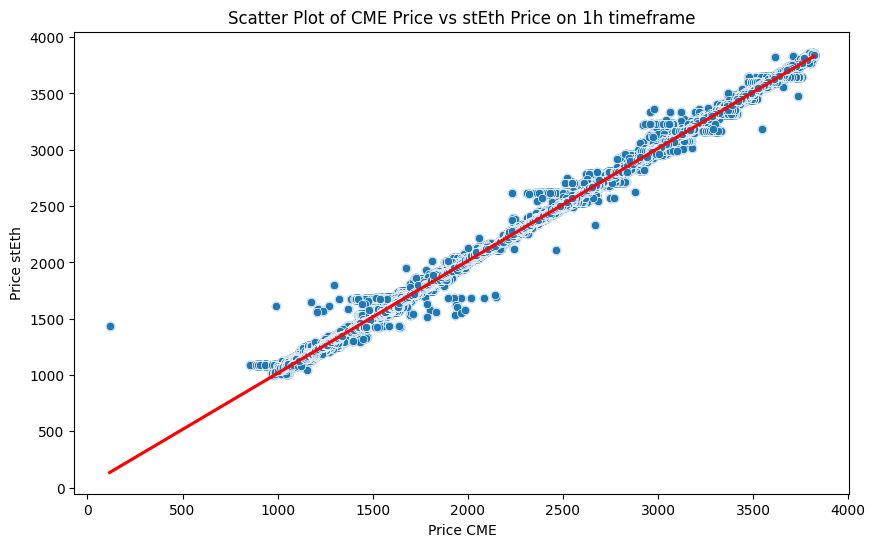

In [83]:
show_scatter(dataset_1h, '1h')

In [84]:
show_pearson_coef(dataset_1h)

Pearson Correlation Coefficient: 0.9985290823487663


In [85]:
dataset_1h.describe()

,Entry Date UTC,Price_cme,Price_steth
count,19333,19333.000000,19333.000000
mean,2023-02-28 01:12:02.681425408,2030.949620,2016.884270
min,2022-01-02 23:00:00,1003.000000,116.660000
25%,2022-08-01 09:00:00,1585.500000,1574.280000
50%,2023-02-27 14:00:00,1843.000000,1834.610000
75%,2023-09-25 18:00:00,2435.500000,2418.540000
max,2024-04-30 23:00:00,3861.500000,3821.190000
std,NaN,669.040271,669.379128


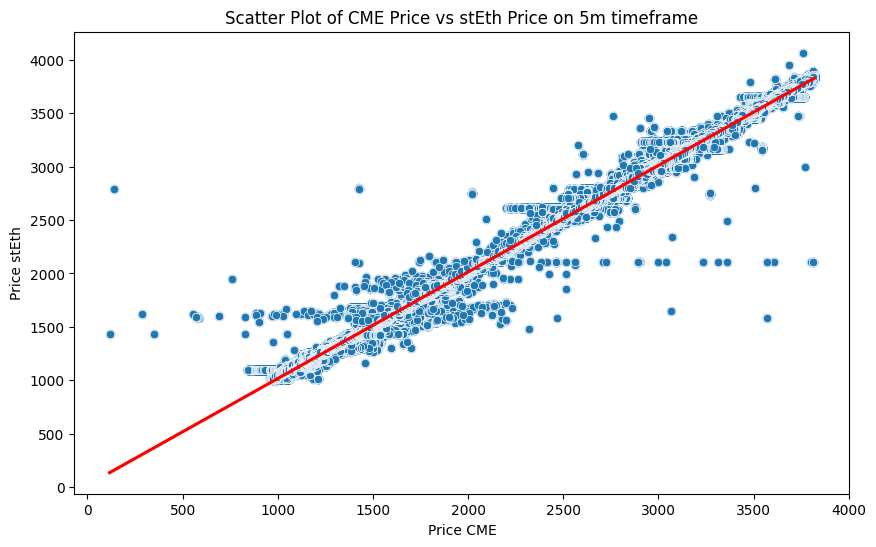

In [86]:
show_scatter(dataset_5m, '5m')

In [87]:
show_pearson_coef(dataset_5m)

Pearson Correlation Coefficient: 0.9983430191739039


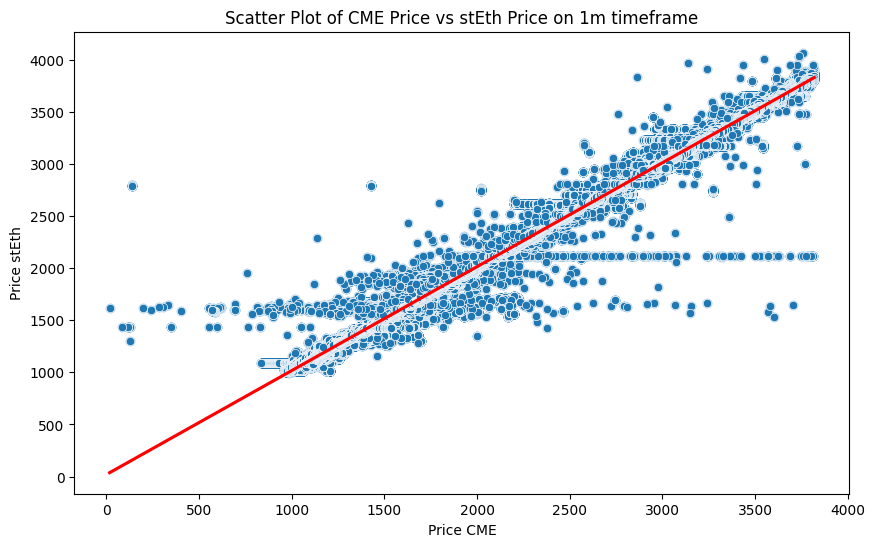

In [88]:
show_scatter(dataset_1m, '1m')

In [89]:
show_pearson_coef(dataset_1m)

Pearson Correlation Coefficient: 0.9983392919022325
